In [ ]:
# SAFE VIDEO LABELING SCRIPT

import os
import shutil
import pandas as pd

# CONFIGURATION

LABELS_CSV = "/kaggle/input/lables/video_labels.csv"
VIDEO_DIR  = "/kaggle/input/echo-data/echo"      # mixed videos
OUT_DIR    = "/kaggle/working/labeled_videos" # output
VIDEO_EXTS = (".mp4", ".avi", ".mov", ".mkv")

# STEP 1 — LOAD LABELS

labels = pd.read_csv(LABELS_CSV)
labels.columns = labels.columns.str.strip()

print("Labels loaded")
print("Rows in labels file:", len(labels))
print("Label distribution:")
print(labels["label"].value_counts())

# STEP 2 — BASIC VALIDATION

required_cols = {"HashedFileName", "label"}
if not required_cols.issubset(labels.columns):
    raise ValueError(f"CSV must contain columns: {required_cols}")

# STEP 3 — PREPARE OUTPUT FOLDERS

for lbl in labels["label"].unique():
    os.makedirs(os.path.join(OUT_DIR, f"class_{lbl}"), exist_ok=True)

# STEP 4 — INDEX EXISTING VIDEOS

video_index = {
    os.path.splitext(f)[0]: f
    for f in os.listdir(VIDEO_DIR)
    if f.lower().endswith(VIDEO_EXTS)
}

print("\nVideos found in folder:", len(video_index))

# STEP 5 — COPY VIDEOS

copied = 0
missing = 0

for _, row in labels.iterrows():
    vid_id = row["HashedFileName"]
    label  = row["label"]

    if vid_id in video_index:
        src = os.path.join(VIDEO_DIR, video_index[vid_id])
        dst = os.path.join(OUT_DIR, f"class_{label}", video_index[vid_id])

        shutil.copy2(src, dst)   # SAFE COPY
        copied += 1
    else:
        missing += 1

# STEP 6 — FINAL REPORT

print("\n================ FINAL REPORT ================")
print("Videos copied successfully:", copied)
print("Labels without matching video:", missing)
print("Output folder:", OUT_DIR)
print("==============================================")


Labels loaded
Rows in labels file: 11702
Label distribution:
label
0    7288
1    4414
Name: count, dtype: int64

Videos found in folder: 943

================ FINAL REPORT ================
Videos copied successfully: 924
Labels without matching video: 10778
Output folder: /kaggle/working/labeled_videos


In [2]:
!pip install -q fvcore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import os, random, cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.hub
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ---------------- CONFIG ----------------
DATA_DIR = "/kaggle/working/labeled_videos"
OUTPUT_DIR = "/kaggle/working/x3d_out"
os.makedirs(OUTPUT_DIR, exist_ok=True)

NUM_FRAMES = 32
FRAME_SIZE = 224
BATCH_SIZE = 4
EPOCHS = 25
LR = 1e-4
SEED = 42

# Decision threshold
LVH_THRESHOLD = 0.35

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [ ]:
#Dataset (X3D-safe spatial augmentation)

class VideoDataset(Dataset):
    def __init__(self, df, num_frames=NUM_FRAMES, size=FRAME_SIZE, train=True):
        self.df = df.reset_index(drop=True)
        self.num_frames = num_frames
        self.train = train

        if train:
            self.transform = T.Compose([
                T.ToPILImage(),
                T.Resize((size + 32, size + 32)),
                T.RandomCrop(size),
                T.RandomHorizontalFlip(p=0.5),
                T.ColorJitter(brightness=0.2, contrast=0.2),
                T.ToTensor(),
                T.Normalize(
                    mean=[0.43216, 0.394666, 0.37645],
                    std=[0.22803, 0.22145, 0.216989]
                )
            ])
        else:
            self.transform = T.Compose([
                T.ToPILImage(),
                T.Resize((size, size)),
                T.ToTensor(),
                T.Normalize(
                    mean=[0.43216, 0.394666, 0.37645],
                    std=[0.22803, 0.22145, 0.216989]
                )
            ])

    def __len__(self):
        return len(self.df)

    def _temporal_sample(self, frames):
        n = len(frames)
        if self.train:
            start = random.randint(0, max(0, n - self.num_frames))
            idx = list(range(start, min(start + self.num_frames, n)))
        else:
            idx = np.linspace(0, n - 1, self.num_frames).astype(int)

        if len(idx) < self.num_frames:
            idx += [idx[-1]] * (self.num_frames - len(idx))

        return frames[idx]

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        cap = cv2.VideoCapture(row["path"])

        frames = []
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
        cap.release()

        frames = self._temporal_sample(np.array(frames))
        frames = [self.transform(f) for f in frames]

        # (T,C,H,W) → (C,T,H,W)
        clip = torch.stack(frames).permute(1, 0, 2, 3)
        return clip, int(row["label"])


In [5]:
rows = []
for cls in ["class_0", "class_1"]:
    for f in os.listdir(os.path.join(DATA_DIR, cls)):
        if f.lower().endswith((".mp4", ".avi", ".mov", ".mkv")):
            rows.append({
                "path": os.path.join(DATA_DIR, cls, f),
                "label": int(cls.split("_")[-1])
            })

df = pd.DataFrame(rows)

train_df, test_df = train_test_split(df, test_size=0.15, stratify=df["label"], random_state=SEED)
train_df, val_df  = train_test_split(train_df, test_size=0.1765, stratify=train_df["label"], random_state=SEED)

train_loader = DataLoader(VideoDataset(train_df, train=True),
                          batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

val_loader   = DataLoader(VideoDataset(val_df, train=False),
                          batch_size=BATCH_SIZE, num_workers=0)

test_loader  = DataLoader(VideoDataset(test_df, train=False),
                          batch_size=BATCH_SIZE, num_workers=0)

print("Train / Val / Test:", len(train_df), len(val_df), len(test_df))


Train / Val / Test: 646 139 139


In [ ]:
model = torch.hub.load(
    "facebookresearch/pytorchvideo",
    "x3d_m",
    pretrained=True
)

# Custom head (ONLY head modified)
in_features = model.blocks[-1].proj.in_features
model.blocks[-1].proj = nn.Sequential(
    nn.Linear(in_features, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 2)
)

model = model.to(device)
print(" X3D loaded with custom projection head")


Downloading: "https://github.com/facebookresearch/pytorchvideo/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/pytorchvideo/model_zoo/kinetics/X3D_M.pyth" to /root/.cache/torch/hub/checkpoints/X3D_M.pyth
100%|██████████| 29.4M/29.4M [00:00<00:00, 112MB/s] 


✅ X3D loaded with custom projection head


In [ ]:
# Compute class weights from training data
neg = (train_df["label"] == 0).sum()
pos = (train_df["label"] == 1).sum()

class_weights = torch.tensor(
    [1.0, neg / pos],
    dtype=torch.float32,
    device=device
)

criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

scaler = torch.cuda.amp.GradScaler()

/tmp/ipykernel_47/3595529828.py:15: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [13]:
torch.cuda.empty_cache()

In [ ]:
best_val = 0.0
best_path = os.path.join(OUTPUT_DIR, "best_x3d_weighted.pth")

from torch import amp

scaler = torch.cuda.amp.GradScaler()

for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss = 0.0

    for x, y in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}"):

        x = x.to(device, non_blocking=True)
        y = y.to(device).long()

        optimizer.zero_grad()

        # Mixed precision forward
        with amp.autocast(device_type="cuda"):
            logits = model(x)
            loss = criterion(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()

    # ---------- Validation ----------
    model.eval()
    preds, gts = [], []

    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            probs = torch.softmax(logits, dim=1)[:, 1]
            preds.extend((probs >= LVH_THRESHOLD).cpu().numpy())
            gts.extend(y.cpu().numpy())

    val_acc = accuracy_score(gts, preds)
    print(f"Epoch {epoch} | train_loss={train_loss:.4f} | val_acc={val_acc:.4f}")

    if val_acc > best_val:
        best_val = val_acc
        torch.save(model.state_dict(), best_path)
        print(" Saved best model")


/tmp/ipykernel_47/2800145046.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Epoch 1/25:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 1 | train_loss=110.9149 | val_acc=0.4388
✅ Saved best model


Epoch 2/25:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 2 | train_loss=103.3684 | val_acc=0.5755
✅ Saved best model


Epoch 3/25:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 3 | train_loss=95.7374 | val_acc=0.6259
✅ Saved best model


Epoch 4/25:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 4 | train_loss=85.2864 | val_acc=0.6619
✅ Saved best model


Epoch 5/25:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 5 | train_loss=85.5628 | val_acc=0.4748


Epoch 6/25:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 6 | train_loss=75.2908 | val_acc=0.5827


Epoch 7/25:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 7 | train_loss=71.4394 | val_acc=0.6906
✅ Saved best model


Epoch 8/25:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 8 | train_loss=63.5711 | val_acc=0.7122
✅ Saved best model


Epoch 9/25:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 9 | train_loss=59.0711 | val_acc=0.6763


Epoch 10/25:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 10 | train_loss=56.3536 | val_acc=0.7050


Epoch 11/25:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 11 | train_loss=50.4256 | val_acc=0.6978


Epoch 12/25:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 12 | train_loss=38.9520 | val_acc=0.6547


Epoch 13/25:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 13 | train_loss=42.4129 | val_acc=0.7410
✅ Saved best model


Epoch 14/25:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 14 | train_loss=35.6812 | val_acc=0.7122


Epoch 15/25:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 15 | train_loss=30.1486 | val_acc=0.7338


Epoch 16/25:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 16 | train_loss=28.1579 | val_acc=0.6978


Epoch 17/25:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 17 | train_loss=30.4164 | val_acc=0.7626
✅ Saved best model


Epoch 18/25:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 18 | train_loss=23.1454 | val_acc=0.5180


Epoch 19/25:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 19 | train_loss=17.7462 | val_acc=0.7410


Epoch 20/25:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 20 | train_loss=22.1277 | val_acc=0.6547


Epoch 21/25:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 21 | train_loss=15.7051 | val_acc=0.6475


Epoch 22/25:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 22 | train_loss=15.1674 | val_acc=0.6763


Epoch 23/25:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 23 | train_loss=23.5088 | val_acc=0.6403


Epoch 24/25:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 24 | train_loss=10.8700 | val_acc=0.7050


Epoch 25/25:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 25 | train_loss=19.5901 | val_acc=0.7338



📊 CLASSIFICATION REPORT

              precision    recall  f1-score   support

  No LVH (0)     0.7500    0.7079    0.7283        89
     LVH (1)     0.5273    0.5800    0.5524        50

    accuracy                         0.6619       139
   macro avg     0.6386    0.6439    0.6404       139
weighted avg     0.6699    0.6619    0.6650       139


🧮 CONFUSION MATRIX (Raw Counts)

[[63 26]
 [21 29]]


<Figure size 600x600 with 0 Axes>

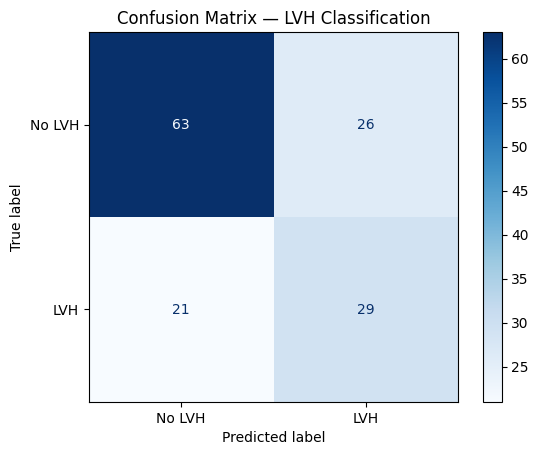

In [ ]:
# =========================================
# CONFUSION MATRIX + CLASSIFICATION REPORT
# =========================================

import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay
)

# Make sure model is in eval mode
model.eval()

y_true = []
y_pred = []

# --------- COLLECT PREDICTIONS ----------
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)

        logits = model(x)
        preds = torch.argmax(logits, dim=1)

        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# --------- CLASSIFICATION REPORT ----------
print("\n CLASSIFICATION REPORT\n")
print(
    classification_report(
        y_true,
        y_pred,
        target_names=["No LVH (0)", "LVH (1)"],
        digits=4
    )
)

# --------- CONFUSION MATRIX (NUMERIC) ----------
cm = confusion_matrix(y_true, y_pred)
print("\n CONFUSION MATRIX (Raw Counts)\n")
print(cm)

# --------- CONFUSION MATRIX (PLOT) ----------
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["No LVH", "LVH"]
)

plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix — LVH Classification")
plt.grid(False)
plt.show()



📊 CLASSIFICATION REPORT (Threshold = 0.4 )

              precision    recall  f1-score   support

  No LVH (0)     0.7451    0.8539    0.7958        89
     LVH (1)     0.6486    0.4800    0.5517        50

    accuracy                         0.7194       139
   macro avg     0.6969    0.6670    0.6738       139
weighted avg     0.7104    0.7194    0.7080       139


🧮 CONFUSION MATRIX (Raw Counts)

[[76 13]
 [26 24]]


<Figure size 600x600 with 0 Axes>

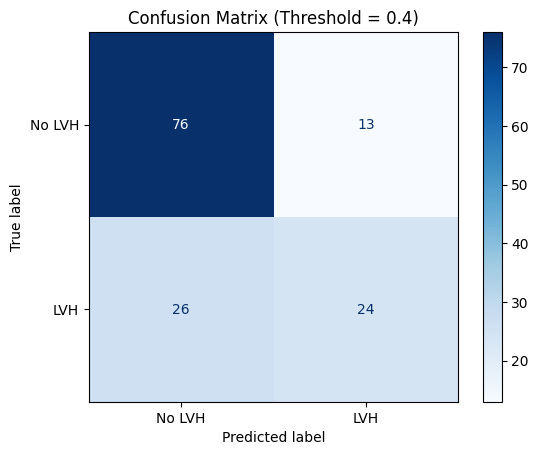

In [ ]:

# THRESHOLD-AWARE CONFUSION MATRIX + REPORT

import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay
)

# -------- CONFIG --------
LVH_THRESHOLD = 0.40   #  use your tuned threshold
model.eval()

y_true = []
y_pred = []

# --------- COLLECT PREDICTIONS ----------
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)

        logits = model(x)

        # Convert logits → probability → threshold
        probs = torch.softmax(logits, dim=1)[:, 1]
        preds = (probs >= LVH_THRESHOLD).long()

        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# --------- CLASSIFICATION REPORT ----------
print("\n CLASSIFICATION REPORT (Threshold =", LVH_THRESHOLD, ")\n")
print(
    classification_report(
        y_true,
        y_pred,
        target_names=["No LVH (0)", "LVH (1)"],
        digits=4
    )
)

# --------- CONFUSION MATRIX ----------
cm = confusion_matrix(y_true, y_pred)

print("\n CONFUSION MATRIX (Raw Counts)\n")
print(cm)

# --------- CONFUSION MATRIX (PLOT) ----------
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["No LVH", "LVH"]
)

plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", values_format="d")
plt.title(f"Confusion Matrix (Threshold = {LVH_THRESHOLD})")
plt.grid(False)
plt.show()


In [173]:
# -------- CONFIG --------
VIDEO_PATH = "/kaggle/input/test002/WhatsApp Video 2026-01-02 at 17.00.17.mp4"
MODEL_PATH = "/kaggle/working/x3d_out/best_x3d_weighted.pth"

NUM_FRAMES = 16
FRAME_SIZE = 224
LVH_THRESHOLD = 0.35    # same threshold you used in testing

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# -------- LOAD MODEL --------
model = torch.hub.load(
    "facebookresearch/pytorchvideo",
    "x3d_m",
    pretrained=False
)

# same custom head as training
in_features = model.blocks[-1].proj.in_features
model.blocks[-1].proj = nn.Sequential(
    nn.Linear(in_features, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 2)
)

model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model = model.to(device)
model.eval()

print(" Model loaded for inference")


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


✅ Model loaded for inference


In [ ]:
# -------- PREPROCESS VIDEO --------
import torchvision.transforms as T
import cv2
import numpy as np

transform = T.Compose([
    T.ToPILImage(),
    T.Resize((FRAME_SIZE, FRAME_SIZE)),
    T.ToTensor(),
    T.Normalize(
        mean=[0.43216, 0.394666, 0.37645],
        std=[0.22803, 0.22145, 0.216989]
    )
])

def load_video_clip(path, num_frames=NUM_FRAMES):
    cap = cv2.VideoCapture(path)
    frames = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

    cap.release()

    if len(frames) == 0:
        raise RuntimeError(" Empty or unreadable video")

    # Uniform temporal sampling
    idx = np.linspace(0, len(frames) - 1, num_frames).astype(int)
    frames = [frames[i] for i in idx]

    frames = [transform(f) for f in frames]

    # (T,C,H,W) → (C,T,H,W) → add batch dim
    clip = torch.stack(frames).permute(1, 0, 2, 3).unsqueeze(0)
    return clip


In [ ]:
# -------- RUN INFERENCE --------
clip = load_video_clip(VIDEO_PATH).to(device)

with torch.no_grad():
    logits = model(clip)
    probs = torch.softmax(logits, dim=1)[0]

lvh_prob = probs[1].item()
prediction = int(lvh_prob >= LVH_THRESHOLD)

print("\n INFERENCE RESULT")
print(f"LVH probability : {lvh_prob:.4f}")
print(f"Prediction      : {'LVH (1)' if prediction == 1 else 'No LVH (0)'}")



📊 INFERENCE RESULT
LVH probability : 0.1262
Prediction      : No LVH (0)


In [ ]:
import torch

MODEL_PATH = "/kaggle/working/x3d_out/best_x3d_weighted.pth"
ONNX_PATH  = "/kaggle/working/x3d_lvh.onnx"

# Load model architecture
model = torch.hub.load(
    "facebookresearch/pytorchvideo",
    "x3d_m",
    pretrained=False
)

in_features = model.blocks[-1].proj.in_features
model.blocks[-1].proj = torch.nn.Sequential(
    torch.nn.Linear(in_features, 128),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(128, 2)
)

model.load_state_dict(torch.load(MODEL_PATH, map_location="cpu"))
model.eval()

# Dummy input (1 video)
dummy_input = torch.randn(1, 3, 16, 224, 224)

torch.onnx.export(
    model,
    dummy_input,
    ONNX_PATH,
    input_names=["video"],
    output_names=["logits"],
    dynamic_axes={
        "video": {0: "batch_size"},
        "logits": {0: "batch_size"}
    },
    opset_version=17
)

print(" Model exported to ONNX:", ONNX_PATH)


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


✅ Model exported to ONNX: /kaggle/working/x3d_lvh.onnx


In [ ]:
# -------- CONFIG --------
VIDEO_PATH = "/kaggle/input/test003/WhatsApp Video 2026-01-02 at 17.05.40.mp4"
MODEL_PATH = "/kaggle/working/x3d_out/best_x3d_weighted.pth"

NUM_FRAMES = 16
FRAME_SIZE = 224
LVH_THRESHOLD = 0.37    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# -------- LOAD MODEL --------
import torch
import torch.nn as nn

model = torch.hub.load(
    "facebookresearch/pytorchvideo",
    "x3d_m",
    pretrained=False
)

# same custom head as training
in_features = model.blocks[-1].proj.in_features
model.blocks[-1].proj = nn.Sequential(
    nn.Linear(in_features, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 2)
)

model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model = model.to(device)
model.eval()

print(" Model loaded for inference")


# -------- PREPROCESS VIDEO --------
import torchvision.transforms as T
import cv2
import numpy as np

transform = T.Compose([
    T.ToPILImage(),
    T.Resize((FRAME_SIZE, FRAME_SIZE)),
    T.ToTensor(),
    T.Normalize(
        mean=[0.43216, 0.394666, 0.37645],
        std=[0.22803, 0.22145, 0.216989]
    )
])

def load_video_clip(path, num_frames=NUM_FRAMES):
    cap = cv2.VideoCapture(path)
    frames = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

    cap.release()

    if len(frames) == 0:
        raise RuntimeError(" Empty or unreadable video")

    # Uniform temporal sampling
    idx = np.linspace(0, len(frames) - 1, num_frames).astype(int)
    frames = [frames[i] for i in idx]

    frames = [transform(f) for f in frames]

    # (T,C,H,W) → (C,T,H,W) → add batch dim
    clip = torch.stack(frames).permute(1, 0, 2, 3).unsqueeze(0)
    return clip


# -------- RUN INFERENCE --------
clip = load_video_clip(VIDEO_PATH).to(device)

with torch.no_grad():
    logits = model(clip)
    probs = torch.softmax(logits, dim=1)[0]

lvh_prob = probs[1].item()
prediction = int(lvh_prob >= LVH_THRESHOLD)

print("\n INFERENCE RESULT")
print(f"LVH probability : {lvh_prob:.4f}")
print(f"Threshold       : {LVH_THRESHOLD}")
print(f"Prediction      : {'LVH (1)' if prediction == 1 else 'No LVH (0)'}")


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


✅ Model loaded for inference

📊 INFERENCE RESULT
LVH probability : 0.9918
Threshold       : 0.37
Prediction      : LVH (1)
